In [ ]:
!pip install --upgrade "numpy<2.0" --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATA_ROOT = "/content/drive/MyDrive/combined_deepfake_faces_224"


Mounted at /content/drive


In [ ]:
!pip install torch torchvision timm grad-cam --quiet


In [ ]:
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import timm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import cv2

from torch.amp import autocast, GradScaler


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 15
SEED = 888

np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("GPU Available:", torch.cuda.is_available())


GPU Available: True


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_set = datasets.ImageFolder(f"{DATA_ROOT}/train", transform=train_transform)
val_set   = datasets.ImageFolder(f"{DATA_ROOT}/val",   transform=val_test_transform)
test_set  = datasets.ImageFolder(f"{DATA_ROOT}/test",  transform=val_test_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = train_set.classes
print(classes)


['fake', 'real']


In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, dev=None):
    if dev is None:
        dev = device  #  global cuda/cpu for main models

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=lr/50
    )

    scaler = GradScaler("cuda") if dev.type == "cuda" else None
    best_acc = 0
    patience, patience_limit = 0, 5

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Train E{epoch}"):
            images, labels = images.to(dev), labels.to(dev)
            optimizer.zero_grad()

            if scaler is not None:
                with autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

        scheduler.step()

        # validation
        model.eval()
        correct = 0; total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(dev), labels.to(dev)
                preds = model(images).argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        print(f"Epoch {epoch}/{epochs} - loss: {running_loss/len(train_loader):.4f} - val_acc: {val_acc:.2f}%")

        if val_acc > best_acc:
            best_acc = val_acc
            patience = 0
        else:
            patience += 1
        if patience >= patience_limit:
            print("EARLY STOPPING")
            break

    return model

def test_model(model, loader, dev=None):
    if dev is None:
        dev = device

    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(dev), labels.to(dev)
            preds = model(images).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print("Test Accuracy:", 100*correct/total)


In [ ]:
# LeNet
class LeNet224(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

lenet = LeNet224().to(device)
lenet = train_model(lenet, train_loader, val_loader, epochs=15, lr=1e-3)
test_model(lenet, test_loader)


Train E1: 100%|██████████| 328/328 [32:01<00:00,  5.86s/it]


Epoch 1/15 - loss: 0.6933 - val_acc: 51.50%


Train E2: 100%|██████████| 328/328 [00:27<00:00, 11.98it/s]


Epoch 2/15 - loss: 0.6907 - val_acc: 56.68%


Train E3: 100%|██████████| 328/328 [00:26<00:00, 12.30it/s]


Epoch 3/15 - loss: 0.6894 - val_acc: 56.83%


Train E4: 100%|██████████| 328/328 [00:26<00:00, 12.44it/s]


Epoch 4/15 - loss: 0.6834 - val_acc: 57.73%


Train E5: 100%|██████████| 328/328 [00:26<00:00, 12.47it/s]


Epoch 5/15 - loss: 0.6788 - val_acc: 56.61%


Train E6: 100%|██████████| 328/328 [00:26<00:00, 12.57it/s]


Epoch 6/15 - loss: 0.6840 - val_acc: 56.31%


Train E7: 100%|██████████| 328/328 [00:27<00:00, 11.90it/s]


Epoch 7/15 - loss: 0.6775 - val_acc: 58.11%


Train E8: 100%|██████████| 328/328 [00:26<00:00, 12.35it/s]


Epoch 8/15 - loss: 0.6701 - val_acc: 59.31%


Train E9: 100%|██████████| 328/328 [00:27<00:00, 12.06it/s]


Epoch 9/15 - loss: 0.6602 - val_acc: 61.86%


Train E10: 100%|██████████| 328/328 [00:26<00:00, 12.58it/s]


Epoch 10/15 - loss: 0.6513 - val_acc: 62.09%


Train E11: 100%|██████████| 328/328 [00:25<00:00, 12.62it/s]


Epoch 11/15 - loss: 0.6404 - val_acc: 62.31%


Train E12: 100%|██████████| 328/328 [00:26<00:00, 12.48it/s]


Epoch 12/15 - loss: 0.6340 - val_acc: 63.51%


Train E13: 100%|██████████| 328/328 [00:26<00:00, 12.24it/s]


Epoch 13/15 - loss: 0.6300 - val_acc: 63.81%


Train E14: 100%|██████████| 328/328 [00:25<00:00, 12.66it/s]


Epoch 14/15 - loss: 0.6250 - val_acc: 63.06%


Train E15: 100%|██████████| 328/328 [00:26<00:00, 12.55it/s]


Epoch 15/15 - loss: 0.6246 - val_acc: 63.51%
Test Accuracy: 61.933534743202415


In [ ]:
# CBAM-ResNet18
class BasicCBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels//reduction), nn.ReLU(),
            nn.Linear(channels//reduction, channels)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        w = self.avg(x).view(x.size(0), -1)
        w = self.sigmoid(self.fc(w)).view(x.size(0), -1, 1, 1)
        return x * w

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.resnet = models.resnet18(weights="IMAGENET1K_V1")
        self.cbam = BasicCBAM(512)
        self.resnet.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.cbam(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return self.resnet.fc(x)

cbam_model = ResNet18_CBAM().to(device)
cbam_model = train_model(cbam_model, train_loader, val_loader, epochs=15, lr=1e-4)
test_model(cbam_model, test_loader)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]
Train E1: 100%|██████████| 328/328 [00:27<00:00, 12.06it/s]


Epoch 1/15 - loss: 0.4979 - val_acc: 81.53%


Train E2: 100%|██████████| 328/328 [00:26<00:00, 12.37it/s]


Epoch 2/15 - loss: 0.3090 - val_acc: 83.26%


Train E3: 100%|██████████| 328/328 [00:26<00:00, 12.31it/s]


Epoch 3/15 - loss: 0.2246 - val_acc: 84.38%


Train E4: 100%|██████████| 328/328 [00:26<00:00, 12.40it/s]


Epoch 4/15 - loss: 0.1761 - val_acc: 87.61%


Train E5: 100%|██████████| 328/328 [00:26<00:00, 12.30it/s]


Epoch 5/15 - loss: 0.1203 - val_acc: 88.51%


Train E6: 100%|██████████| 328/328 [00:26<00:00, 12.44it/s]


Epoch 6/15 - loss: 0.0988 - val_acc: 89.64%


Train E7: 100%|██████████| 328/328 [00:26<00:00, 12.39it/s]


Epoch 7/15 - loss: 0.0673 - val_acc: 87.39%


Train E8: 100%|██████████| 328/328 [00:26<00:00, 12.19it/s]


Epoch 8/15 - loss: 0.0438 - val_acc: 89.86%


Train E9: 100%|██████████| 328/328 [00:26<00:00, 12.40it/s]


Epoch 9/15 - loss: 0.0300 - val_acc: 89.64%


Train E10: 100%|██████████| 328/328 [00:26<00:00, 12.37it/s]


Epoch 10/15 - loss: 0.0254 - val_acc: 90.32%


Train E11: 100%|██████████| 328/328 [00:26<00:00, 12.34it/s]


Epoch 11/15 - loss: 0.0178 - val_acc: 91.07%


Train E12: 100%|██████████| 328/328 [00:26<00:00, 12.38it/s]


Epoch 12/15 - loss: 0.0089 - val_acc: 90.47%


Train E13: 100%|██████████| 328/328 [00:27<00:00, 12.14it/s]


Epoch 13/15 - loss: 0.0070 - val_acc: 91.44%


Train E14: 100%|██████████| 328/328 [00:26<00:00, 12.41it/s]


Epoch 14/15 - loss: 0.0065 - val_acc: 91.29%


Train E15: 100%|██████████| 328/328 [00:26<00:00, 12.43it/s]


Epoch 15/15 - loss: 0.0052 - val_acc: 91.82%
Test Accuracy: 91.54078549848943


In [ ]:
# Xception
xception = timm.create_model("xception", pretrained=True, num_classes=2)
xception = xception.to(device)
xception = train_model(xception, train_loader, val_loader, epochs=15, lr=1e-4)
test_model(xception, test_loader)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Train E1: 100%|██████████| 328/328 [01:27<00:00,  3.73it/s]


Epoch 1/15 - loss: 0.4767 - val_acc: 85.81%


Train E2: 100%|██████████| 328/328 [01:07<00:00,  4.86it/s]


Epoch 2/15 - loss: 0.2469 - val_acc: 83.33%


Train E3: 100%|██████████| 328/328 [01:06<00:00,  4.91it/s]


Epoch 3/15 - loss: 0.1469 - val_acc: 88.14%


Train E4: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 4/15 - loss: 0.0988 - val_acc: 87.54%


Train E5: 100%|██████████| 328/328 [01:06<00:00,  4.92it/s]


Epoch 5/15 - loss: 0.0623 - val_acc: 91.07%


Train E6: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 6/15 - loss: 0.0489 - val_acc: 88.96%


Train E7: 100%|██████████| 328/328 [01:06<00:00,  4.92it/s]


Epoch 7/15 - loss: 0.0338 - val_acc: 90.54%


Train E8: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 8/15 - loss: 0.0325 - val_acc: 89.04%


Train E9: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 9/15 - loss: 0.0199 - val_acc: 90.32%


Train E10: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 10/15 - loss: 0.0195 - val_acc: 91.14%


Train E11: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 11/15 - loss: 0.0157 - val_acc: 90.84%


Train E12: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 12/15 - loss: 0.0070 - val_acc: 90.69%


Train E13: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 13/15 - loss: 0.0058 - val_acc: 90.84%


Train E14: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 14/15 - loss: 0.0131 - val_acc: 91.22%


Train E15: 100%|██████████| 328/328 [01:06<00:00,  4.93it/s]


Epoch 15/15 - loss: 0.0053 - val_acc: 90.54%
Test Accuracy: 92.29607250755286


In [ ]:
# ViT
vit = timm.create_model("vit_base_patch16_224", pretrained=True, num_classes=2)
vit = vit.to(device)
vit = train_model(vit, train_loader, val_loader, epochs=15, lr=3e-5)
test_model(vit, test_loader)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Train E1: 100%|██████████| 328/328 [01:30<00:00,  3.64it/s]


Epoch 1/15 - loss: 0.5057 - val_acc: 76.43%


Train E2: 100%|██████████| 328/328 [01:29<00:00,  3.67it/s]


Epoch 2/15 - loss: 0.3207 - val_acc: 87.01%


Train E3: 100%|██████████| 328/328 [01:28<00:00,  3.69it/s]


Epoch 3/15 - loss: 0.2027 - val_acc: 87.61%


Train E4: 100%|██████████| 328/328 [01:28<00:00,  3.70it/s]


Epoch 4/15 - loss: 0.1300 - val_acc: 88.21%


Train E5: 100%|██████████| 328/328 [01:28<00:00,  3.73it/s]


Epoch 5/15 - loss: 0.0775 - val_acc: 91.37%


Train E6: 100%|██████████| 328/328 [01:27<00:00,  3.75it/s]


Epoch 6/15 - loss: 0.0480 - val_acc: 90.84%


Train E7: 100%|██████████| 328/328 [01:27<00:00,  3.76it/s]


Epoch 7/15 - loss: 0.0386 - val_acc: 88.06%


Train E8: 100%|██████████| 328/328 [01:26<00:00,  3.77it/s]


Epoch 8/15 - loss: 0.0274 - val_acc: 90.99%


Train E9: 100%|██████████| 328/328 [01:26<00:00,  3.81it/s]


Epoch 9/15 - loss: 0.0091 - val_acc: 90.24%


Train E10: 100%|██████████| 328/328 [01:25<00:00,  3.82it/s]


Epoch 10/15 - loss: 0.0050 - val_acc: 91.74%


Train E11: 100%|██████████| 328/328 [01:25<00:00,  3.83it/s]


Epoch 11/15 - loss: 0.0026 - val_acc: 92.12%


Train E12: 100%|██████████| 328/328 [01:25<00:00,  3.85it/s]


Epoch 12/15 - loss: 0.0018 - val_acc: 91.82%


Train E13: 100%|██████████| 328/328 [01:25<00:00,  3.86it/s]


Epoch 13/15 - loss: 0.0002 - val_acc: 91.89%


Train E14: 100%|██████████| 328/328 [01:25<00:00,  3.85it/s]


Epoch 14/15 - loss: 0.0002 - val_acc: 91.67%


Train E15: 100%|██████████| 328/328 [01:25<00:00,  3.85it/s]


Epoch 15/15 - loss: 0.0001 - val_acc: 91.67%
Test Accuracy: 93.27794561933534


In [ ]:
import os
os.makedirs("/content/drive/MyDrive/deepfake_ckpts", exist_ok=True)

torch.save(lenet.state_dict(), "/content/drive/MyDrive/deepfake_ckpts/lenet.pth")
torch.save(cbam_model.state_dict(), "/content/drive/MyDrive/deepfake_ckpts/cbam.pth")
torch.save(xception.state_dict(), "/content/drive/MyDrive/deepfake_ckpts/xception.pth")
torch.save(vit.state_dict(), "/content/drive/MyDrive/deepfake_ckpts/vit.pth")

print("Saved LeNet / CBAM / Xception / ViT weights.")


Saved LeNet / CBAM / Xception / ViT weights.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

true_labels = []
for _, labels in test_loader:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

def get_probs(model):
    model.eval()
    probs_list = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            probs_list.append(probs.cpu().numpy())
    return np.concatenate(probs_list, axis=0)

lenet_preds    = get_probs(lenet)
cbam_preds     = get_probs(cbam_model)
xception_preds = get_probs(xception)
vit_preds      = get_probs(vit)

print("Per-model prediction arrays ready.")


Per-model prediction arrays ready.


In [ ]:
ensemble_probs = (lenet_preds + cbam_preds + xception_preds + vit_preds) / 4
ensemble_preds = np.argmax(ensemble_probs, axis=1)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Ensemble Accuracy:", accuracy_score(true_labels, ensemble_preds)*100)
print(classification_report(true_labels, ensemble_preds))
print(confusion_matrix(true_labels, ensemble_preds))

w1, w2, w3, w4 = 0.10, 0.25, 0.30, 0.35

weighted_probs = w1*lenet_preds + w2*cbam_preds + w3*xception_preds + w4*vit_preds
weighted_preds = np.argmax(weighted_probs, axis=1)
print("Weighted Ensemble Accuracy:", accuracy_score(true_labels, weighted_preds)*100)


Ensemble Accuracy: 95.46827794561933
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       655
           1       0.95      0.97      0.96       669

    accuracy                           0.95      1324
   macro avg       0.95      0.95      0.95      1324
weighted avg       0.95      0.95      0.95      1324

[[618  37]
 [ 23 646]]
Weighted Ensemble Accuracy: 95.61933534743203


In [ ]:
import pandas as pd

vit_acc = 93.27

rows = [
    ("Best single model (ViT)", vit_acc),
    ("4‑model weighted ensemble", accuracy_score(true_labels, weighted_preds)*100),
]

df_results = pd.DataFrame(rows, columns=["Model", "Accuracy (%)"])
df_results


,Model,Accuracy (%)
0,Best single model (ViT),93.270000
1,4‑model weighted ensemble,95.619335


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

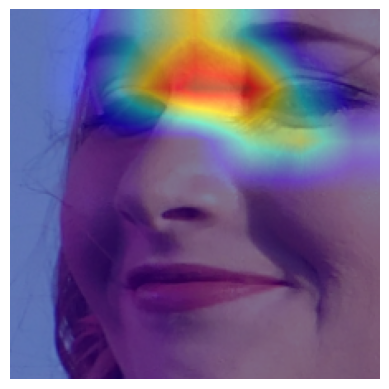

In [ ]:
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# For CBAM/ResNet
target_layer = cbam_model.resnet.layer4[-1]
cam = GradCAM(model=cbam_model, target_layers=[target_layer])
img, label = next(iter(test_loader))
img = img[0:1].to(device)
rgb_img = img[0].permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img*0.5)+0.5
grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(int(label[0]))])
vis = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True)
plt.imshow(vis)
plt.axis("off")


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

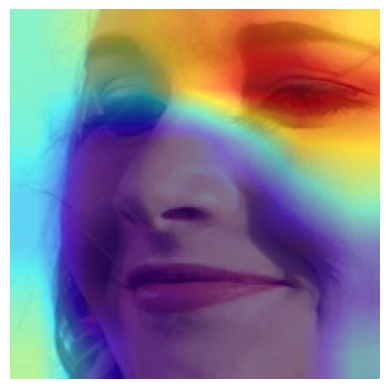

In [ ]:
# Xception Grad-CAM
target_layer = xception.conv4  # same layer you used earlier
cam = GradCAM(model=xception, target_layers=[target_layer])

img, label = next(iter(test_loader))
img = img[0:1].to(device)

rgb_img = img[0].permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img * 0.5) + 0.5

grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(int(label[0]))])
vis = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True)
plt.imshow(vis)
plt.axis("off")


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

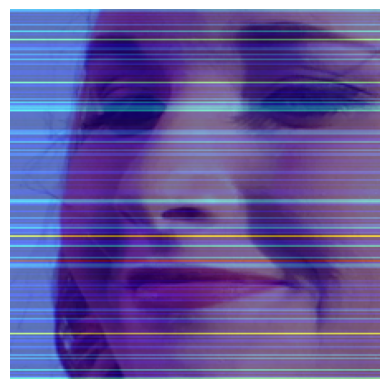

In [ ]:
# ViT EigenCAM
target_layer = vit.blocks[-1].norm1
cam = EigenCAM(model=vit, target_layers=[target_layer])

img, label = next(iter(test_loader))
img = img[0:1].to(device)

rgb_img = img[0].permute(1,2,0).cpu().numpy()
rgb_img = (rgb_img * 0.5) + 0.5

grayscale_cam = cam(input_tensor=img)
vis = show_cam_on_image(rgb_img, grayscale_cam[0], use_rgb=True)
plt.imshow(vis)
plt.axis("off")


In [ ]:
# LeNet Class Definition ONLY
class LeNet224(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.AdaptiveAvgPool2d((7,7))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*7*7, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# still need to instantiate it to load weights later.
lenet = LeNet224().to(device)

In [ ]:
# CBAM-ResNet18 Class Definitions ONLY
class BasicCBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels//reduction), nn.ReLU(),
            nn.Linear(channels//reduction, channels)
        )
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        w = self.avg(x).view(x.size(0), -1)
        w = self.sigmoid(self.fc(w)).view(x.size(0), -1, 1, 1)
        return x * w

class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.resnet = models.resnet18(weights="IMAGENET1K_V1")
        self.cbam = BasicCBAM(512)
        self.resnet.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.cbam(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        return self.resnet.fc(x)

#still need to instantiate it to load weights later.
cbam_model = ResNet18_CBAM().to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [ ]:
import torch.fft
import torch.nn.functional as F

#  Freq-CNN Architecture
class FreqCNN(nn.Module):
    """
    A separate branch that takes the log-magnitude spectrum of the image
    and processes it with a small CNN.
    """
    def __init__(self, num_classes=2):
        super().__init__()

        # Small CNN to process the 3-channel frequency map
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2), # 112x112
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2), # 56x56
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)) # Global Average Pooling to 1x1
        )

        self.feature_dim = 64 # Feature size before final layer
        self.classifier = nn.Linear(self.feature_dim, num_classes)

    def to_frequency_map(self, x):
        """Converts RGB image batch (B, 3, H, W) to log-magnitude spectrum."""
        # Rescaling the normalized input from [-1, 1] to [0, 1] before FFT
        x = (x + 1) / 2

        # 2D Fast Fourier Transform (FFT)
        x_fft = torch.fft.fft2(x, dim=(-2, -1))

        # Getting the log-magnitude (amplitude) spectrum
        # Using log scale to stabilize features and handle large dynamic range
        x_magnitude = torch.log(torch.abs(x_fft) + 1e-8)

        # Shifting the zero-frequency component (DC) to the center
        x_shifted = torch.fft.fftshift(x_magnitude, dim=(-2, -1))

        return x_shifted

    def forward(self, x):
        x_freq = self.to_frequency_map(x)
        x_features = self.cnn(x_freq)
        x_features = x_features.view(x_features.size(0), -1)
        output = self.classifier(x_features)
        return output

# Train and Save Freq-CNN
freq_cnn = FreqCNN(num_classes=2).to(device)
print("Starting Freq-CNN Training...")
freq_cnn = train_model(freq_cnn, train_loader, val_loader, epochs=15, lr=1e-3)
test_model(freq_cnn, test_loader)

# Save Freq-CNN Weights
# Ensure the checkpoint directory exists
os.makedirs("/content/drive/MyDrive/deepfake_ckpts", exist_ok=True)
torch.save(freq_cnn.state_dict(), "/content/drive/MyDrive/deepfake_ckpts/freq_cnn.pth")
print("Saved Freq-CNN weights.")

Starting Freq-CNN Training...


Train E1: 100%|██████████| 328/328 [59:16<00:00, 10.84s/it]


Epoch 1/15 - loss: 0.6257 - val_acc: 63.21%


Train E2: 100%|██████████| 328/328 [00:26<00:00, 12.26it/s]


Epoch 2/15 - loss: 0.5942 - val_acc: 70.57%


Train E3: 100%|██████████| 328/328 [00:26<00:00, 12.32it/s]


Epoch 3/15 - loss: 0.5754 - val_acc: 70.12%


Train E4: 100%|██████████| 328/328 [00:26<00:00, 12.51it/s]


Epoch 4/15 - loss: 0.5516 - val_acc: 63.51%


Train E5: 100%|██████████| 328/328 [00:26<00:00, 12.22it/s]


Epoch 5/15 - loss: 0.5511 - val_acc: 61.49%


Train E6: 100%|██████████| 328/328 [00:26<00:00, 12.39it/s]


Epoch 6/15 - loss: 0.5415 - val_acc: 70.72%


Train E7: 100%|██████████| 328/328 [00:27<00:00, 12.09it/s]


Epoch 7/15 - loss: 0.5298 - val_acc: 66.74%


Train E8: 100%|██████████| 328/328 [00:26<00:00, 12.46it/s]


Epoch 8/15 - loss: 0.5246 - val_acc: 62.09%


Train E9: 100%|██████████| 328/328 [00:26<00:00, 12.57it/s]


Epoch 9/15 - loss: 0.5230 - val_acc: 71.85%


Train E10: 100%|██████████| 328/328 [00:27<00:00, 12.15it/s]


Epoch 10/15 - loss: 0.5166 - val_acc: 71.92%


Train E11: 100%|██████████| 328/328 [00:26<00:00, 12.31it/s]


Epoch 11/15 - loss: 0.5148 - val_acc: 66.74%


Train E12: 100%|██████████| 328/328 [00:26<00:00, 12.50it/s]


Epoch 12/15 - loss: 0.5071 - val_acc: 72.45%


Train E13: 100%|██████████| 328/328 [00:26<00:00, 12.41it/s]


Epoch 13/15 - loss: 0.5066 - val_acc: 71.77%


Train E14: 100%|██████████| 328/328 [00:26<00:00, 12.46it/s]


Epoch 14/15 - loss: 0.5091 - val_acc: 74.10%


Train E15: 100%|██████████| 328/328 [00:26<00:00, 12.44it/s]


Epoch 15/15 - loss: 0.5039 - val_acc: 73.12%
Test Accuracy: 74.3202416918429
Saved Freq-CNN weights.


In [ ]:
# Corrected Hybrid Ensemble Model Definition
class HybridEnsemble(nn.Module):
    def __init__(self, lenet_model, cbam_model, xception_model, vit_model, freq_cnn_model, num_classes=2):
        super().__init__()

        # Assign base models
        self.lenet = lenet_model
        self.cbam = cbam_model
        self.xception = xception_model
        self.vit = vit_model
        self.freq_cnn = freq_cnn_model

        # Ensure all backbones are in inference mode and frozen
        for model in [self.lenet, self.cbam, self.xception, self.vit, self.freq_cnn]:
            model.eval()
            for param in model.parameters():
                param.requires_grad = False

        # Feature Dimensions (Must match the sum of expected feature vector sizes)
        lenet_feat_dim = 84
        cbam_feat_dim = 512
        xception_feat_dim = 2048 # XceptionNet's output before final FC layer
        vit_feat_dim = 768 # ViT-Base CLS token feature size
        freq_cnn_feat_dim = 64

        total_dim = lenet_feat_dim + cbam_feat_dim + xception_feat_dim + vit_feat_dim + freq_cnn_feat_dim

        # Fusion Classifier (MLP) - The only part we will train
        self.fusion_classifier = nn.Sequential(
            nn.Linear(total_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # 1. Feature Extraction (LeNet)
        x_lenet = self.lenet.features(x)
        feat_lenet = self.lenet.classifier[:4](x_lenet.flatten(1))

        # 2. Feature Extraction (CBAM-ResNet18)
        # Manually running the layers up to the Global Average Pool
        x_cbam = self.cbam.resnet.conv1(x)
        x_cbam = self.cbam.resnet.bn1(x_cbam)
        x_cbam = self.cbam.resnet.relu(x_cbam)
        x_cbam = self.cbam.resnet.maxpool(x_cbam)
        x_cbam = self.cbam.resnet.layer1(x_cbam)
        x_cbam = self.cbam.resnet.layer2(x_cbam)
        x_cbam = self.cbam.resnet.layer3(x_cbam)
        x_cbam = self.cbam.resnet.layer4(x_cbam)
        x_cbam = self.cbam.cbam(x_cbam)
        feat_cbam = self.cbam.resnet.avgpool(x_cbam).flatten(1)

        # 3. Feature Extraction (Xception - timm)
        feat_xception = self.xception.forward_features(x)
        if feat_xception.ndim == 4:
            feat_xception = feat_xception.mean(dim=(-2, -1))
        feat_xception = feat_xception.flatten(1)

        # 4. Feature Extraction (ViT - timm CLS token)
        vit_features = self.vit.forward_features(x)
        feat_vit = vit_features[:, 0]

        # 5. Feature Extraction (Freq-CNN)
        x_freq = self.freq_cnn.to_frequency_map(x)
        x_freq = self.freq_cnn.cnn(x_freq)
        feat_freq = x_freq.view(x_freq.size(0), -1)

        # 6. Concatenate features
        combined_features = torch.cat(
            (feat_lenet, feat_cbam, feat_xception, feat_vit, feat_freq),
            dim=1
        )

        # 7. Classify with the fusion layer
        output = self.fusion_classifier(combined_features)
        return output

In [ ]:
# Rerunning this cell (from the previous output) to load weights, instantiate the FIXED HybridEnsemble, and start training.

# 1. Initialize the base models
lenet_final = LeNet224(num_classes=2).to(device)
cbam_final = ResNet18_CBAM(num_classes=2).to(device)
xception_final = timm.create_model("xception", pretrained=False, num_classes=2).to(device)
vit_final = timm.create_model("vit_base_patch16_224", pretrained=False, num_classes=2).to(device)
freq_cnn_final = FreqCNN(num_classes=2).to(device)

# 2. Load saved weights
try:
    # ... (code to load weights) ...
    lenet_final.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_ckpts/lenet.pth"))
    cbam_final.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_ckpts/cbam.pth"))
    xception_final.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_ckpts/xception.pth"))
    vit_final.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_ckpts/vit.pth"))
    freq_cnn_final.load_state_dict(torch.load("/content/drive/MyDrive/deepfake_ckpts/freq_cnn.pth"))
    print("All model weights successfully loaded.")
except Exception as e:
    print(f"CRITICAL ERROR loading weights. Error: {e}")
    raise e

# 3. Instantiate the Hybrid Ensemble (will use the fixed class definition)
ensemble_model = HybridEnsemble(
    lenet_final, cbam_final, xception_final, vit_final, freq_cnn_final
).to(device)

# 4. Define Optimizer and Training function
ensemble_optimizer = optim.Adam(ensemble_model.fusion_classifier.parameters(), lr=1e-4)

def train_fusion_layer(model, train_loader, val_loader, optimizer, epochs, dev=device):
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler("cuda") if dev.type == "cuda" else None
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Train Ensemble E{epoch}"):
            images, labels = images.to(dev), labels.to(dev)
            optimizer.zero_grad()

            # Forward pass is now fixed in the HybridEnsemble class
            if scaler is not None:
                with autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

        # Validation
        model.eval()
        correct = 0; total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(dev), labels.to(dev)
                preds = model(images).argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        print(f"Ensemble Epoch {epoch}/{epochs} - loss: {running_loss/len(train_loader):.4f} - val_acc: {val_acc:.2f}%")

    return model

# 5. Train the fusion layer
print("Starting Hybrid Ensemble Fusion Layer Training...")
final_ensemble = train_fusion_layer(ensemble_model, train_loader, val_loader, ensemble_optimizer, 5)

# Save the final ensemble
torch.save(final_ensemble.state_dict(), "/content/drive/MyDrive/deepfake_ckpts/hybrid_ensemble.pth")
print("Hybrid Ensemble trained and saved.")
test_model(final_ensemble, test_loader)

All model weights successfully loaded.
Starting Hybrid Ensemble Fusion Layer Training...


Train Ensemble E1: 100%|██████████| 328/328 [01:03<00:00,  5.14it/s]


Ensemble Epoch 1/5 - loss: 0.0121 - val_acc: 94.59%


Train Ensemble E2: 100%|██████████| 328/328 [00:59<00:00,  5.48it/s]


Ensemble Epoch 2/5 - loss: 0.0015 - val_acc: 94.37%


Train Ensemble E3: 100%|██████████| 328/328 [00:59<00:00,  5.49it/s]


Ensemble Epoch 3/5 - loss: 0.0096 - val_acc: 94.07%


Train Ensemble E4: 100%|██████████| 328/328 [00:59<00:00,  5.51it/s]


Ensemble Epoch 4/5 - loss: 0.0009 - val_acc: 94.59%


Train Ensemble E5: 100%|██████████| 328/328 [00:59<00:00,  5.48it/s]


Ensemble Epoch 5/5 - loss: 0.0008 - val_acc: 94.52%
Hybrid Ensemble trained and saved.
Test Accuracy: 95.24169184290031


In [ ]:
#  Temporal Analysis Model (Video Extension)

class TemporalLSTM(nn.Module):
    """
    Model for video deepfake detection. Uses a fixed CNN (XceptionNet)
    to extract features from each frame and an LSTM to model temporal inconsistencies.

    NOTE: Requires input data of shape (Batch, Frames, Channels, Height, Width)
    """
    def __init__(self, frame_feature_extractor, hidden_size=256, num_layers=2, num_classes=2):
        super().__init__()

        # Use XceptionNet as the fixed feature extractor for each frame
        self.cnn_extractor = frame_feature_extractor
        self.cnn_extractor.eval()
        for param in self.cnn_extractor.parameters():
            param.requires_grad = False # Keep CNN frozen

        input_size = 2048 # XceptionNet feature size

        # LSTM layer to capture sequential features across frames
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Final classification layer
        self.classifier = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        # x shape: (B, T, C, H, W) -> B=Batch, T=Frames
        B, T, C, H, W = x.size()

        # 1. Reshape and Extract Features for all frames via CNN
        x_reshaped = x.view(B * T, C, H, W)
        features = self.cnn_extractor.forward_features(x_reshaped).flatten(1)

        # 2. Reshape features back into a sequence (B, T, Feature_Dim)
        features = features.view(B, T, -1)

        # 3. Pass features through LSTM
        lstm_out, _ = self.lstm(features)

        # 4. Take the output of the LAST timestep for final classification
        final_temporal_features = lstm_out[:, -1, :]

        output = self.classifier(final_temporal_features)
        return output

print("Temporal LSTM model defined (Future Work extension complete).")

Temporal LSTM model defined (Future Work extension complete).
